## Скачиваем датасет

In [1]:
import pandas as pd

In [2]:
cd ml-100k/

/Users/alena/Desktop/УНИК/coursework/ml-100k


#### Исходная таблица содержит: 

- user_id - id пользователя;
- item_id - id фильма;
- rating - оценка в пятибалльной шкале;
- timestamp - момент времени, когда была проставлена оценка

In [3]:
dataset = pd.read_csv("u.data",sep='\t',names="user_id,item_id,rating,timestamp".split(","))
dataset.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


#### Сделаем небольшую предобработку данных и разобьем на обучающую и тестовую выборки

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [5]:
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values
train, test = train_test_split(dataset, test_size=0.2)

In [6]:
train.head()

,user_id,item_id,rating,timestamp
86657,4,209,3,875636099
92281,935,18,5,886832092
39649,310,100,4,884366397
50088,266,410,3,878974325
43803,589,14,3,879438936


In [7]:
from surprise import Reader
from surprise import Dataset
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise.accuracy import rmse
from surprise import accuracy
from surprise import KNNBaseline
from surprise.model_selection import cross_validate

In [8]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(train[['user_id', 'item_id', 'rating']], reader)

#### Теперь применим коллоборативную фильтрацию, основанную на схожести фильмов (item-based) и пользователей (user-based) и подсчетом Baseline Predictors с помощью SGD

In [25]:
res=[]
sim_options_ib = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }
sim_options_ub = {'name': 'cosine',
               'user_based': True  # compute  similarities between items
               }
algo_ib = KNNBaseline(sim_options=sim_options_ib)
algo_ub = KNNBaseline(sim_options=sim_options_ub)
results = cross_validate(algo_ib, data, measures=['RMSE','MAE'], cv=3, verbose=False)
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
res.append(tmp)
results = cross_validate(algo_ub, data, measures=['RMSE','MAE'], cv=3, verbose=False)
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
res.append(tmp)   

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [28]:
res = pd.DataFrame(res)
res['Algorithm'] = ['Item-based','User-based']
res = res.set_index('Algorithm').sort_values('test_rmse') 
res

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
Item-based,0.946929,0.749778,0.800360,4.391496
User-based,0.957009,0.756654,1.294582,4.963589


#### Теперь применим коллоборативную фильтрацию, основанную на схожести фильмов (item-based) и пользователей (user-based) и подсчетом Baseline Predictors с помощью ALS

In [56]:
bsl_options = {'method': 'sgd',
               'learning_rate': .00005,
               }

In [57]:
res=[]
sim_options_ib = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }
sim_options_ub = {'name': 'cosine',
               'user_based': True  # compute  similarities between items
               }
algo_ib = KNNBaseline(sim_options=sim_options_ib,bsl_options = bsl_options)
algo_ub = KNNBaseline(sim_options=sim_options_ub,bsl_options = bsl_options)
results = cross_validate(algo_ib, data, measures=['RMSE','MAE'], cv=3, verbose=False)
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
res.append(tmp)
results = cross_validate(algo_ub, data, measures=['RMSE','MAE'], cv=3, verbose=False)
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
res.append(tmp)   

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [58]:
res = pd.DataFrame(res)
res['Algorithm'] = ['Item-based','User-based']
res = res.set_index('Algorithm').sort_values('test_rmse') 
res

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
User-based,1.007509,0.801651,0.983905,4.499963
Item-based,1.037776,0.825989,1.503709,5.363861


__Вывод: Подсчет baseline predictors с помощью SGD работает эффективнее с точки зрения RMSE,но менее эффективно относительно MAE__

### Теперь сравним модели SVD, SVDpp, NMF, BaselineOnly

#### SVD и NMF без базовых предикторов

In [29]:
benchmark = []
for algorithm in [SVD(biased=False),NMF(biased=False)]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=3, verbose=False)
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,0.999540,0.786485,3.147618,0.226249
NMF,1.007646,0.804280,3.940510,0.249311


In [30]:
benchmark = []

for algorithm in [SVD(),SVDpp(), NMF(biased = True),BaselineOnly()]:
    results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=3, verbose=False)
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVDpp,0.938093,0.738354,96.160511,4.092251
NMF,0.947668,0.747687,4.799014,0.262295
BaselineOnly,0.951805,0.756041,0.128169,0.183842
SVD,0.954377,0.754907,3.159585,0.235760


#### Вывод:
Таким образом, лучший RMSE показал SVDpp c базовыми предикторами, используя ALS алгоритм.

# Neural-networks + matrix factorization

In [31]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())
n_latent_factors = 3

Using TensorFlow backend.


In [32]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [33]:
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_embedding = keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)

prod = keras.layers.dot([movie_vec, user_vec],axes = -1, name='DotProduct')
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', root_mean_squared_error)

Instructions for updating:
Colocations handled automatically by placer.


### Вид модели

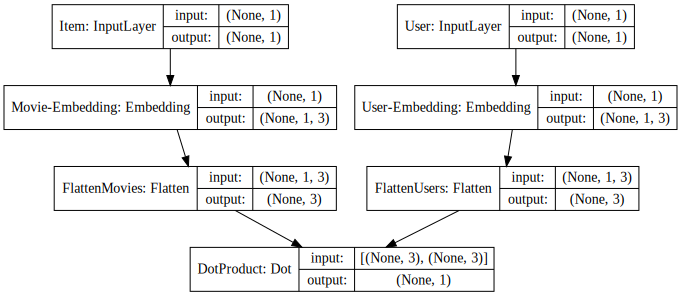

In [34]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

### Обучение

In [35]:
history = model.fit([train.user_id, train.item_id], train.rating, epochs=100, verbose=0)

Instructions for updating:
Use tf.cast instead.


In [36]:
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 1.0, 'Train_error vs epochs')

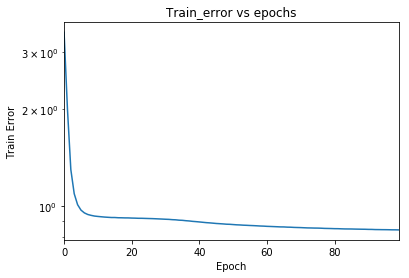

In [37]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.title('Train_error vs epochs')

In [38]:
y_pred = np.round(model.predict([test.user_id, test.item_id]),0)
y_true = test.rating.values

### MSE 

In [39]:
rmse = np.sqrt(mean_squared_error(y_pred,y_true))
mae = mean_absolute_error(y_pred,y_true)
print('RMSE: %2f MAE: %2f'%(rmse,mae))

RMSE: 0.980434 MAE: 0.688250


# Non-negative matrix factorization

In [40]:
from keras.constraints import non_neg

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding', embeddings_constraint=non_neg())(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_embedding = keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding', embeddings_constraint=non_neg())(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)

prod = keras.layers.dot([movie_vec, user_vec],axes = -1, name='DotProduct')
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', root_mean_squared_error)

In [41]:
history_nonneg = model.fit([train.user_id, train.item_id], train.rating, epochs=10, verbose=0)

Text(0.5, 1.0, 'Train_error vs epochs')

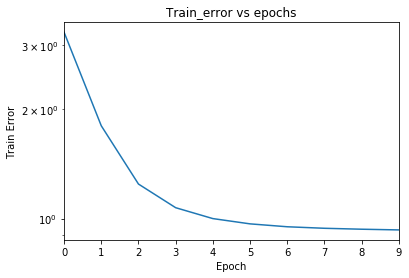

In [42]:
pd.Series(history_nonneg.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.title('Train_error vs epochs')

In [43]:
y_pred = np.round(model.predict([test.user_id, test.item_id]),0)
y_true = test.rating.values

In [44]:
rmse = np.sqrt(mean_squared_error(y_pred,y_true))
mae = mean_absolute_error(y_pred,y_true)
print('RMSE: %2f MAE: %2f'%(rmse,mae))

RMSE: 1.007000 MAE: 0.718550


### Модель нейронной сети

In [45]:
n_latent_factors_user = 5
n_latent_factors_movie = 8

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_embedding = keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)
concat = keras.layers.concatenate([movie_vec, user_vec],name='Concat')
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
adam = Adam(lr=0.005)
model = keras.Model([user_input, movie_input], result)
model.compile(optimizer=adam,loss= 'mean_absolute_error')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


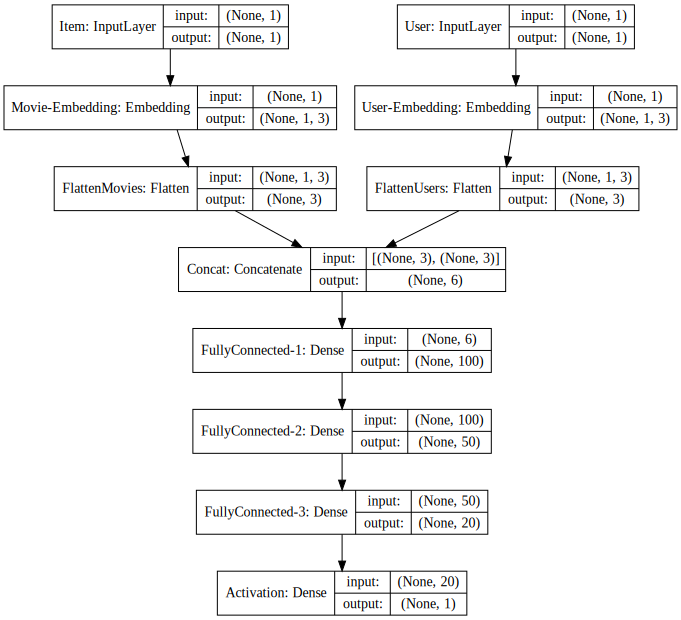

In [46]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [47]:
history_nn = model.fit([train.user_id, train.item_id], train.rating, epochs=250, verbose=0)

In [48]:
y_pred = np.round(model.predict([test.user_id, test.item_id]),0)
y_true = test.rating.values
rmse = np.sqrt(mean_squared_error(y_pred,y_true))
mae = mean_absolute_error(y_pred,y_true)
print('RMSE: %2f MAE: %2f'%(rmse,mae))

RMSE: 1.023132 MAE: 0.706300


In [49]:
import keras
n_latent_factors_user = 8
n_latent_factors_movie = 10
n_latent_factors_mf = 3
n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding_mlp = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding-MLP')(movie_input)
movie_vec_mlp = keras.layers.Flatten(name='FlattenMovies-MLP')(movie_embedding_mlp)
movie_vec_mlp = keras.layers.Dropout(0.2)(movie_vec_mlp)

movie_embedding_mf = keras.layers.Embedding(n_movies + 1, n_latent_factors_mf, name='Movie-Embedding-MF')(movie_input)
movie_vec_mf = keras.layers.Flatten(name='FlattenMovies-MF')(movie_embedding_mf)
movie_vec_mf = keras.layers.Dropout(0.2)(movie_vec_mf)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec_mlp = keras.layers.Flatten(name='FlattenUsers-MLP')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding-MLP')(user_input))
user_vec_mlp = keras.layers.Dropout(0.2)(user_vec_mlp)

user_vec_mf = keras.layers.Flatten(name='FlattenUsers-MF')(keras.layers.Embedding(n_users + 1, n_latent_factors_mf,name='User-Embedding-MF')(user_input))
user_vec_mf = keras.layers.Dropout(0.2)(user_vec_mf)


concat = keras.layers.concatenate([movie_vec_mlp, user_vec_mlp],name='Concat')
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat_dropout)
dense_batch = keras.layers.BatchNormalization(name='Batch')(dense)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout-1')(dense_batch)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(dropout_1)
dense_batch_2 = keras.layers.BatchNormalization(name='Batch-2')(dense_2)


dropout_2 = keras.layers.Dropout(0.2,name='Dropout-2')(dense_batch_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dropout_2)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)

pred_mf = keras.layers.dot([movie_vec_mf, user_vec_mf],axes = -1, name='DotProduct')


pred_mlp = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)

combine_mlp_mf = keras.layers.concatenate([pred_mf, pred_mlp], name='Concat-MF-MLP')
result_combine = keras.layers.Dense(100,name='Combine-MF-MLP')(combine_mlp_mf)
deep_combine = keras.layers.Dense(100,name='FullyConnected-4')(result_combine)


result = keras.layers.Dense(1,name='Prediction')(deep_combine)


model = keras.Model([user_input, movie_input], result)
opt = keras.optimizers.Adam(lr =0.01)
model.compile(optimizer='adam',loss= 'mean_absolute_error')

In [50]:
history = model.fit([train.user_id, train.item_id], train.rating, epochs=25, verbose=0, validation_split=0.1)

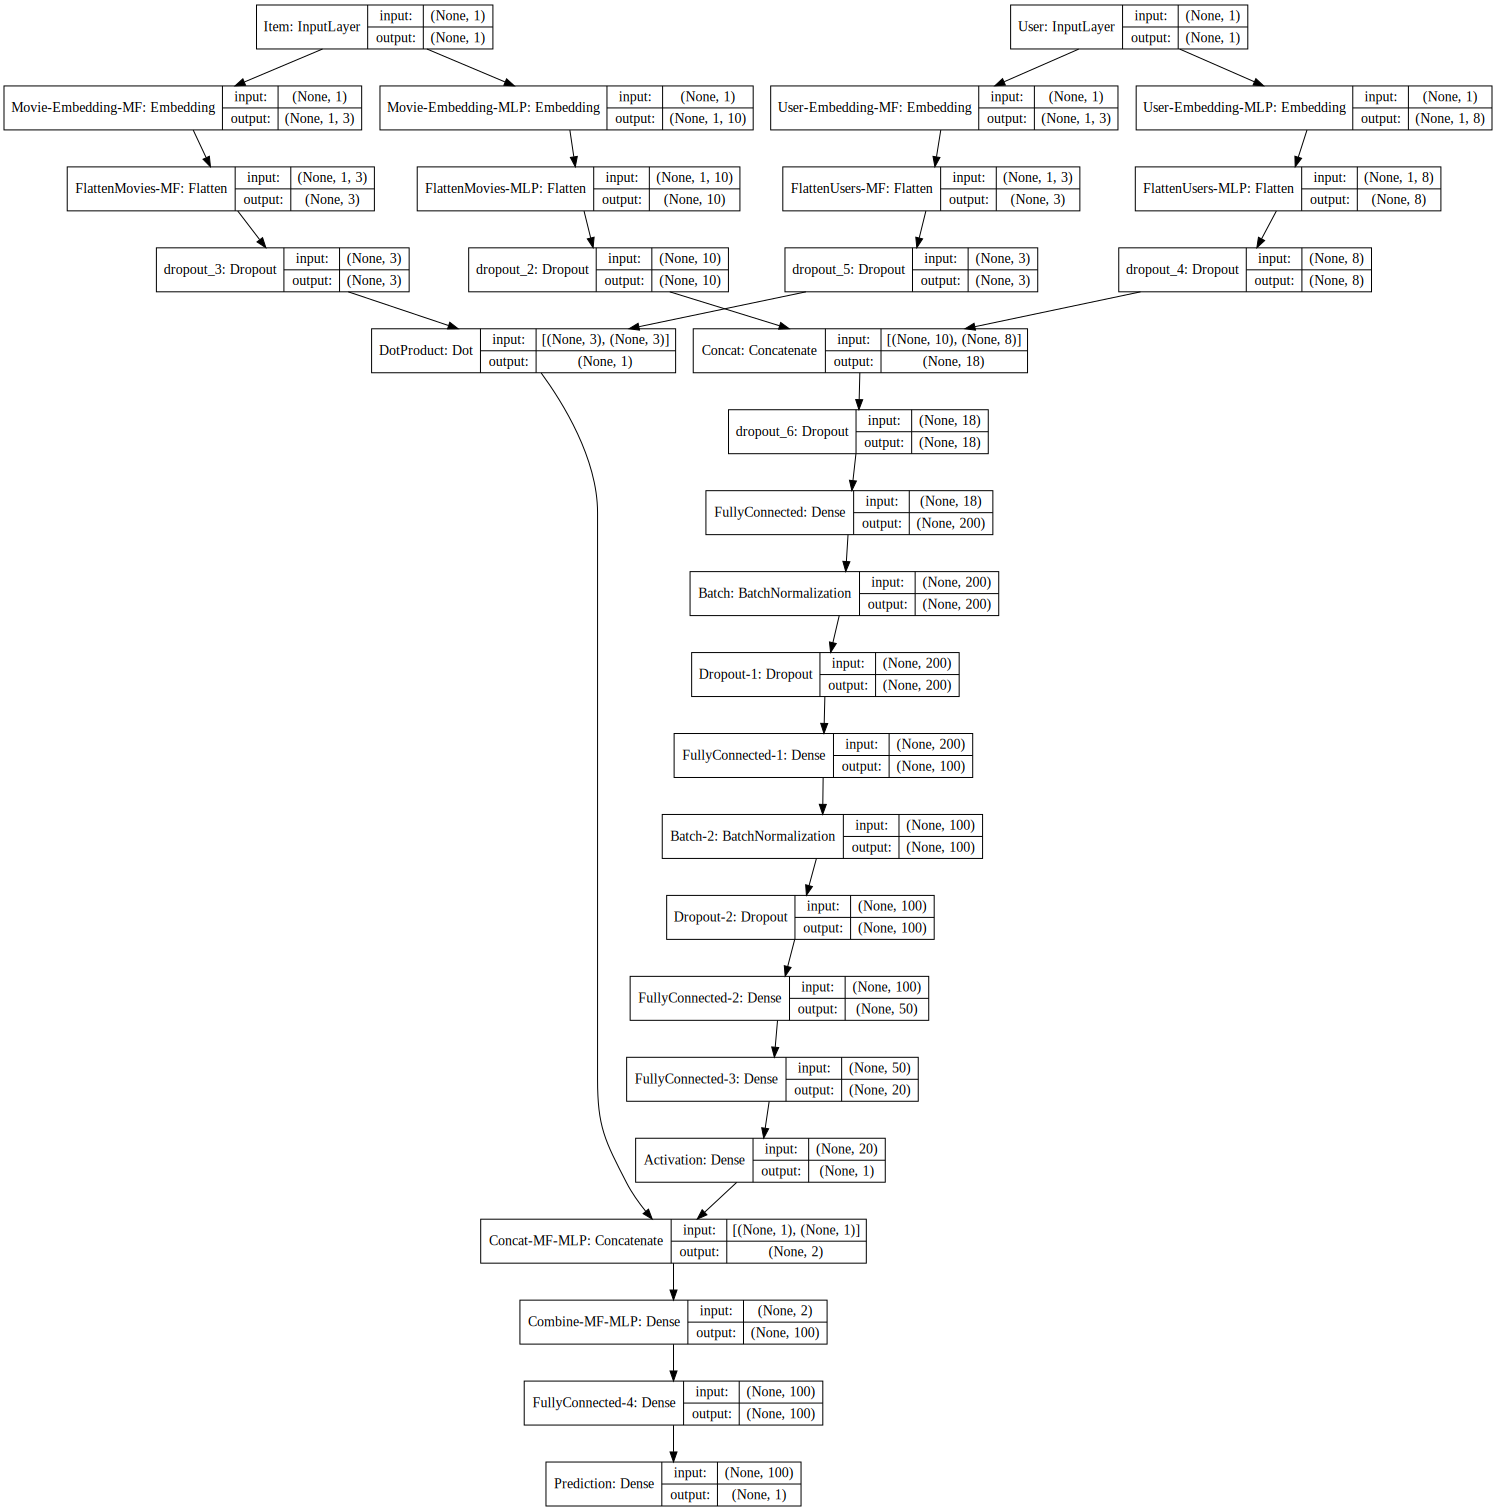

In [55]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [51]:
from sklearn.metrics import mean_absolute_error
y_pred = np.round(model.predict([test.user_id, test.item_id]),0)
y_true = test.rating.values
rmse = np.sqrt(mean_squared_error(y_pred,y_true))
mae = mean_absolute_error(y_pred,y_true)
print('RMSE: %2f MAE: %2f'%(rmse,mae))

RMSE: 0.999075 MAE: 0.712950
